<a href="https://colab.research.google.com/github/abenfaddoul/Image-Classification-in-E-Commerce/blob/main/Vision_Transformers_for_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Image Classification in E-Commerce:**

```
*Vision Transformers for Image Classification*
We will work with the PyTorch library to build and train a vision transformer specifically for image classification tasks
```




Setup
For this lab, we will be using the following libraries:

**numpy** for mathematical and array operations.

**sklearn** for machine learning and machine-learning-pipeline related functions.

**torchvision** for deep learning and neural network-related functions.

**torch** for multi-dimensional tensors and mathematical operations over tensors.

**matplotlib** for additional plotting tools.

**PIL** for loading images.

In [2]:
import os
from PIL import Image
import numpy as np
## Imports for plotting
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.utils import make_grid
import torch.nn as nn
from torchvision import transforms
from matplotlib.pyplot import figure
from sklearn.manifold import TSNE
from tqdm import tqdm

import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR

In [6]:
def plot_samples(dataset, size_even=6, classes=None):

    size_even = 6  # Default number of samples to plot
    dataset = train_set  # Default dataset to use (assuming 'train_set')
    fig, axs = plt.subplots(2, int(size_even // 2))  # Create subplots for the samples

    if classes is None:
        classes = tuple([n for n in range(len(dataset))])  # Default class labels

    n_samples = len(dataset)  # Total number of samples in the dataset

    # Randomly select samples
    samples = np.random.randint(0, high=n_samples - 1, size=int(size_even))

    row = 0
    col = 0
    for n, sample in enumerate(samples):
        img = dataset[sample][0]  # Get the image from the dataset
        label = "y={}".format(classes[int(dataset[sample][1])])  # Get the label for the image

        col = n

        # Determine the row and column index for the current sample
        if n > size_even / 2 - 1:
            row = 1
            col = n - int(size_even / 2)

        # Display the image and label in the corresponding subplot
        axs[row, col].imshow(make_grid(img, normalize=True).permute(1, 2, 0))
        axs[row, col].set_title(label)
        axs[row, col].axis('off')

In [5]:
def plot_image_patchs(patchs, seq=False):

    if patchs.shape[-3] == 1:
        patchs = patchs.repeat(1, 1, 3, 1, 1)  # Add 3 channel dimension if image is grayscale

    N_patchs = patchs.shape[1]  # Number of image patches

    plot_patchs = make_grid(patchs, normalize=True).permute(0, 2, 3, 1)  # Arrange patches for plotting

    N_rows = int(np.sqrt(N_patchs))  # Number of rows for the grid plot

    # Create subplots for the image patches
    if seq:
        fig, ax = plt.subplots(1, N_rows * N_rows, sharex='col', sharey='row', figsize=(25, 5))
        fig.suptitle("Image as Sequence")
    else:
        fig, ax = plt.subplots(N_rows, N_rows, sharex='col', sharey='row')
        fig.suptitle("Image")

    i, j = 0, 0
    for n in range(N_patchs):
        if seq:
            ax[n].imshow(plot_patchs[n])
            ax[n].set_xlabel(str(n + 1))
            ax[n].axes.xaxis.set_ticklabels([])
            ax[n].axes.yaxis.set_ticklabels([])
        else:
            if n % N_rows == 0 and n != 0:
                i += 1
                j = 0

            ax[i, j].imshow(plot_patchs[n])
            ax[i, j].set_ylabel(str(n + 1))
            ax[i, j].axes.xaxis.set_ticklabels([])
            ax[i, j].axes.yaxis.set_ticklabels([])
            j += 1

    plt.show()


In [4]:
def plot_patchs_lables(X, y, label=True, p_show=0.5):
    '''
    The code implements a function for plotting t-SNE visualization of patches and their labels, with the option to label each point and control
    the frequency of labeling for the sequence index.

    X: This is a tensor representing the data to be plotted. It should have the shape (sample, patch, dim), where sample is the number of samples, patch is the size of each patch or sequence length, and dim is the number of features for each patch.
    y: This is a tensor representing the labels for each sample. It should have the shape (sample, 1).
    label: This is a boolean value that controls whether to label each data point in the plot. If label is set to True, each data point in the plot will be labeled.
    p_show: This is a float value between 0 and 1 that controls the frequency of labeling for the sequence index. It specifies the probability of showing a label for each data point. For example, if p_show is set to 0.5, then approximately half of the data points will be labeled.
    '''

    # Detach X from its computational graph if it's not a leaf node
    if not (X.is_leaf):
        X = X.detach()

    # Get the shape of the input tensor X
    if X.shape[0] == 49:
        sample = X.shape[1]
        patch = X.shape[0]  # Patch size or sequence length
        dim = X.shape[2]
    if X.shape[0] == 1000:
        sample = X.shape[0]
        patch = X.shape[1]
        dim = X.shape[2]

    # Reshape X and convert it to a numpy array
    X = X.reshape(sample * patch, dim).numpy()

    # Flatten the y tensor and convert it to a numpy array to label each sequence
    colors = y.repeat(patch, 1).T.flatten().numpy()

    # Perform t-SNE on the X data
    X_ = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

    # Create a scatter plot of the t-SNE transformed X data with each class labeled via color
    fig, ax = plt.subplots()
    for color in np.unique(colors):
        temp = colors == color
        ax.scatter(X_[temp, 0], X_[temp, 1], label=color)

    # If the label argument is set to True, add labels to the scatter plot
    if label:
        for i, x in enumerate(X_):
            # Label plots with a probability of p_show
            if np.random.binomial(1, p_show, 1).item() == 1:
                ax.annotate(str(i % patch), (x[0], x[1]))

    # Add a legend to the scatter plot
    ax.legend()

In [3]:
def img_to_patch(x, patch_size, flatten_channels=True):

    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

In [7]:
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_set = torchvision.datasets.MNIST(root='.',train=True, download=True,
                                       transform=transform_mnist)

test_set = torchvision.datasets.MNIST(root='.',train=False, download=True,
                                      transform=transform_mnist)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 34635429.29it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1205078.48it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10252584.90it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7775726.03it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [8]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=True)

In [9]:
it=iter(test_loader)
image=next(it)[0]

In [10]:
B, C, H, W = image.shape
print("batch size: {}, number of channels: {}, height: {},  width: {}".format( B, C, H, W ))

batch size: 1000, number of channels: 1, height: 28,  width: 28


In [11]:
image[0][0].shape

torch.Size([28, 28])

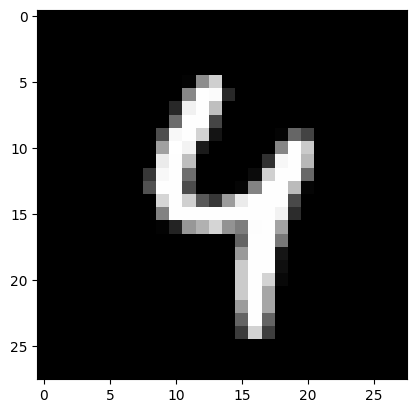

In [12]:
plt.imshow(image[0][0].numpy(),cmap="gray")
plt.show()

In [13]:
patch_size=4

n_patches=(H/patch_size)* (W/patch_size)
n_patches

49.0

In [14]:
patches=img_to_patch(torch.unsqueeze(test_set[1][0],0), patch_size, flatten_channels=False)

In [16]:
patches.shape

torch.Size([1, 49, 1, 4, 4])

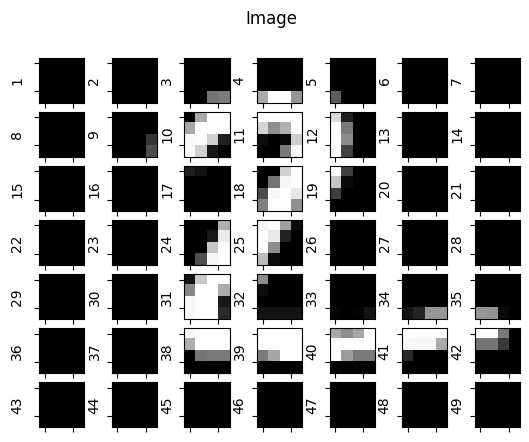

In [17]:
plot_image_patchs(patches)

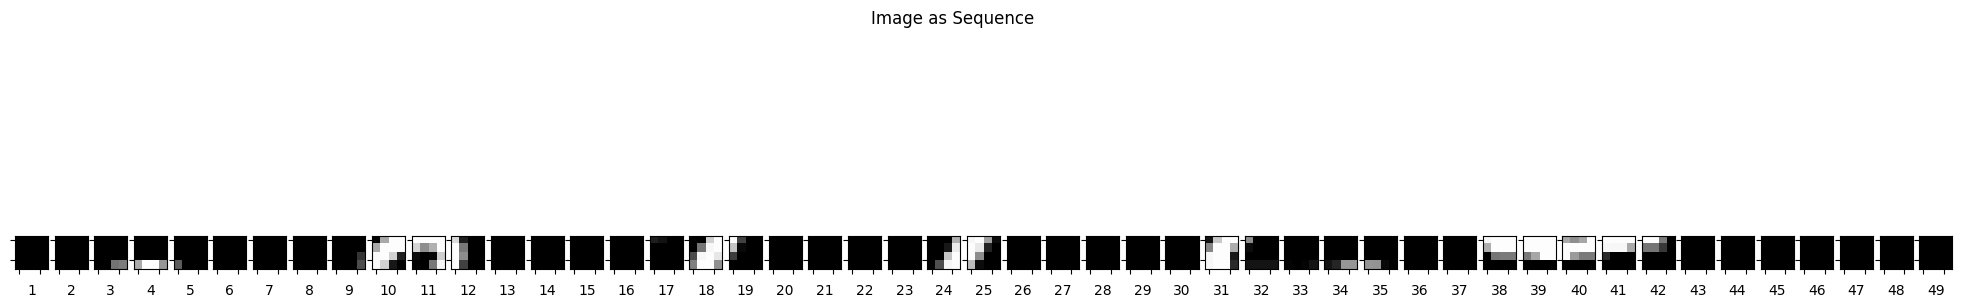

In [18]:
plot_image_patchs(patches, seq=True)

In [19]:
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
            #source:https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )


    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [20]:
class VisionTransformer(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
             #source:https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))
        print(num_patches)


    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)

        x = x + self.pos_embedding[:,:T+1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [21]:
embed_dim= 256
hidden_dim=512
num_heads= 8
num_layers=6
patch_size=4
num_channels=1
num_patches=64
num_classes=10
dropout=0.2
model=VisionTransformer( embed_dim= embed_dim, hidden_dim=hidden_dim, num_channels=num_channels, num_heads=num_heads, num_layers=num_layers, num_classes=num_classes, patch_size=patch_size, num_patches=num_patches, dropout=dropout)

64


In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
device

device(type='cpu')

In [23]:
lr=3e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [ ]:
'''
useful_stuff = {'training_loss': [], 'validation_accuracy': []}
correct_old=0

for epoch in tqdm(range(100)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        model.train()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    scheduler.step()
    useful_stuff['training_loss'].append(running_loss)
    correct = 0
    model.eval()

    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      z = model(inputs)
      _, yhat = torch.max(z, 1)
      correct += (yhat == labels).sum().item()
      if correct>correct_old:
          correct_old=correct

    useful_stuff['validation_accuracy'].append(correct_old/len(test_set))
print('Finished Training')
'''

In [36]:
dataset_url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0CLHEN/gray_5_blocks_v2.pt"
dataset_path = "gray_5_blocks_v2.pt"
torch.save(model.state_dict(), dataset_path)

In [38]:
model.load_state_dict(torch.load('gray_5_blocks_v2.pt',map_location=device))
model.eval()

VisionTransformer(
  (input_layer): Linear(in_features=16, out_features=256, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=512, out_features=256, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): Layer